In [1]:
import geopandas as gpd
import sys
sys.path.append('/home/lpsha/s154446/fractality/dual_graph_algo/')
import dual_conti

from pyrosm import OSM, get_data
import osmnx as ox
import momepy

import matplotlib.pyplot as plt

import numpy as np

# create a polygon of the bounding box
from shapely.geometry import box
from shapely.geometry import LineString

import geopandas as gpd
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm

In [2]:
minx, miny = 12.453, 55.615   # lon, lat (SW)
maxx, maxy = 12.650, 55.735   # lon, lat (NE)

bbox_polygon = box(minx, miny, maxx, maxy)
G = ox.graph.graph_from_polygon(bbox_polygon)

In [3]:
gdf_merged, _, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=20, data=G, enforce_degree2=False)
gdf_merged.crs = 3857

osmnx graph


In [4]:
OSRM = {
    "foot": "http://localhost:5000",
    "bike": "http://localhost:5001",
    "car":  "http://localhost:5002",
}

def get_osrm_route(
    lon1, lat1,
    lon2, lat2,
    mode,
    overview="simplified",
    geometries="geojson",
):
    """
    Query OSRM and return route geometry + metadata.

    mode: one of {"foot", "bike", "car"}
    """
    if mode not in OSRM:
        raise ValueError(f"Unknown mode '{mode}'. Available: {list(OSRM)}")

    url = (
        f"{OSRM[mode]}/route/v1/{mode}/"
        f"{lon1},{lat1};{lon2},{lat2}"
    )

    params = {
        "overview": overview,
        "geometries": geometries,
    }

    r = requests.get(url, params=params)
    r.raise_for_status()

    data = r.json()
    route = data["routes"][0]
    geom = route["geometry"]

    return {
        "mode": mode,
        "geometry": LineString(geom["coordinates"]),
        "distance_m": route["distance"],
        "duration_s": route["duration"],
        "raw": data,
    }

# Simulate

In [14]:
# project roads once
roads_proj = gdf_merged.to_crs(epsg=3857)
roads_buffered = roads_proj.geometry.buffer(5)
roads_buffered_gdf = gpd.GeoDataFrame(
    roads_proj.drop(columns='geometry'), 
    geometry=roads_buffered, 
    crs=roads_proj.crs
)

def degree_sequence(path_geom):
    # project path
    path_proj = (
        gpd.GeoSeries([path_geom], crs=4326)
        .to_crs(roads_proj.crs)
        .iloc[0]
    )

    # proportional sampling (≈1 point every 5 m)
    num_points = max(int(path_proj.length // 5), 2)
    distances = np.linspace(0, path_proj.length, num_points)

    # sample points
    points = [path_proj.interpolate(d) for d in distances]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs=roads_proj.crs)

    # buffer points
    points_buffered = gpd.GeoDataFrame(
        geometry=points_gdf.geometry.buffer(5),
        crs=roads_proj.crs
    )

    # spatial join
    joined = gpd.sjoin(
        points_buffered,
        roads_buffered_gdf[['geometry', 'degree']],
        how='left',
        predicate='intersects'
    )

    # return clean degree sequence
    return joined['degree'].dropna().tolist()

In [27]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)

coords = (
    gdf_merged_4326
    .sample(2)
    .geometry
    .apply(lambda g: (g.coords[0][1], g.coords[0][0]))
    .tolist()
)

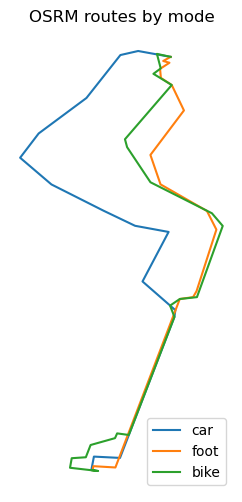

In [30]:
coordsline_car = get_osrm_route(
    coords[0][1], coords[0][0],
    coords[1][1], coords[1][0],
    mode="car"
)

coordsline_foot = get_osrm_route(
    coords[0][1], coords[0][0],
    coords[1][1], coords[1][0],
    mode="foot"
)

coordsline_bike = get_osrm_route(
    coords[0][1], coords[0][0],
    coords[1][1], coords[1][0],
    mode="bike"
)

# plot
fig, ax = plt.subplots(figsize=(6, 6))
for r in [coordsline_car, coordsline_foot, coordsline_bike]:
    x, y = r["geometry"].xy
    ax.plot(x, y, label=r["mode"])
ax.set_aspect("equal")
ax.legend()
ax.set_title("OSRM routes by mode")
plt.axis('off')
plt.show()

In [40]:
gdf_merged_4326 = gdf_merged.to_crs(epsg=4326)

xs_car = []
xs_foot = []
xs_bike = []

ys_car = []
ys_foot = []
ys_bike = []

for _ in tqdm(range(10)):
    try:
        coords = (
            gdf_merged_4326
            .sample(2)
            .geometry
            .apply(lambda g: (g.coords[0][1], g.coords[0][0]))
            .tolist()
        )

        coordsline_car = get_osrm_route(
            coords[0][1], coords[0][0],
            coords[1][1], coords[1][0],
            mode="car"
        )

        coordsline_foot = get_osrm_route(
            coords[0][1], coords[0][0],
            coords[1][1], coords[1][0],
            mode="foot"
        )

        coordsline_bike = get_osrm_route(
            coords[0][1], coords[0][0],
            coords[1][1], coords[1][0],
            mode="bike"
        )



        ds_car = degree_sequence(coordsline_car["geometry"])
        ds_foot = degree_sequence(coordsline_foot["geometry"])
        ds_bike = degree_sequence(coordsline_bike["geometry"])

        ys_car.append(ds_car)
        ys_foot.append(ds_foot)
        ys_bike.append(ds_bike)

        xs_bike.append(np.arange(len(ds_bike)) / len(ds_bike))
        xs_car.append(np.arange(len(ds_car)) / len(ds_car))
        xs_foot.append(np.arange(len(ds_foot)) / len(ds_foot))


    except Exception as e:
        continue

100%|████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.13s/it]


In [49]:
n_bins = 5
bins = np.linspace(0, 1, n_bins + 1)

per_route_means = []

for xs, ys in zip(xs_bike, ys_bike):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    idx = np.digitize(xs, bins) - 1
    idx = np.clip(idx, 0, n_bins - 1)

    route_means = np.array([
        np.mean(ys[idx == i]) if np.any(idx == i) else np.nan
        for i in range(n_bins)
    ])

    per_route_means.append(route_means)

per_route_means = np.vstack(per_route_means)

bin_means = np.nanmean(per_route_means, axis=0)
bin_stds  = np.nanstd(per_route_means, axis=0)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

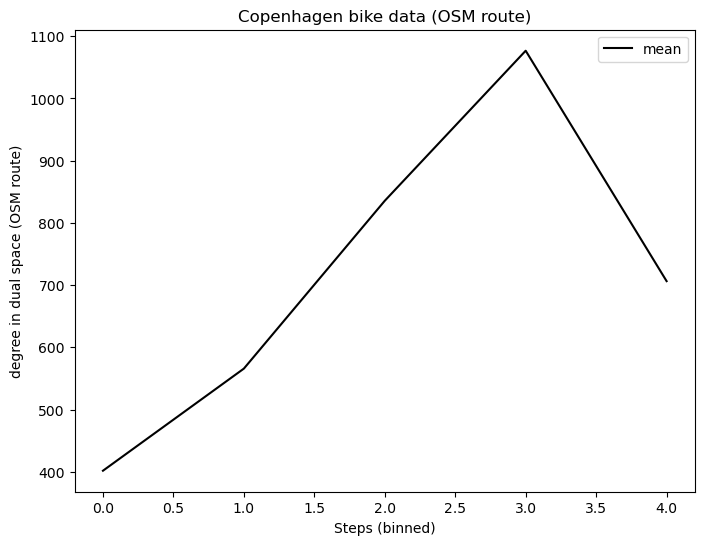

In [50]:
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
ax.plot(bin_means,label='mean',color='k')
plt.legend()
plt.ylabel('degree in dual space (OSM route)')
plt.xlabel('Steps (binned)')
plt.title('Copenhagen bike data (OSM route)')
plt.show()

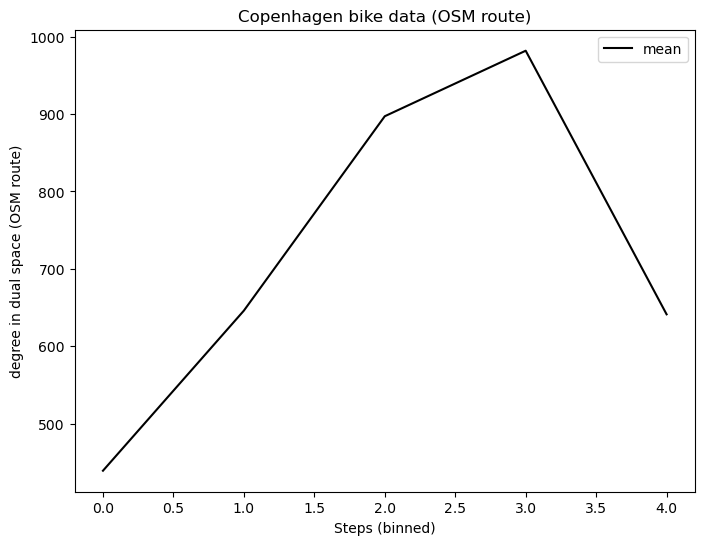

In [48]:
# plot 
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
n_bins = 5
xs_arr = np.concatenate(xs_bike)
ys_arr = np.concatenate(ys_bike)
bins = np.linspace(0, 1, n_bins + 1)
idx = np.digitize(xs_arr, bins) - 1
bin_means = np.array([np.mean(ys_arr[idx == i]) for i in range(n_bins)])
ax.plot(bin_means,label='mean',color='k')
plt.legend()
plt.ylabel('degree in dual space (OSM route)')
plt.xlabel('Steps (binned)')
plt.title('Copenhagen bike data (OSM route)')
plt.show()